In [132]:
# inside loop where window size goes from 100 to 1500
# inside loop that toggles between ordinal encoding and one hot encoding
# extract features and encode surfaces
# train neural network and test it
# print accuracy, precision, recall, f1 score and plot condusion matrix

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal

In [134]:
welch = signal.welch

In [135]:
surfaces_dataset = pd.read_csv('../datasets/final/imu_data_filtered.csv')

In [136]:
features_df = pd.DataFrame(columns=[
    'accel_mean', 'accel_sd', 'accel_min', 'accel_max', 'accel_iqr', 'accel_skew', 'accel_kurtosis', 
    'accel_peak_amp', 'accel_peak_amp_freq', 'accel_peak_pow', 'accel_peak_pow_freq', 
    'gyro_mean', 'gyro_sd', 'gyro_min', 'gyro_max', 'gyro_iqr', 'gyro_skew', 'gyro_kurtosis', 
    'gyro_peak_amp', 'gyro_peak_amp_freq', 'gyro_peak_pow', 'gyro_peak_pow_freq', 
    'surface'
])

def peak_amp(df, feature):
    sampling_freq = 100
    fds = np.fft.fft(df[feature])  # find FFT using numpy (frequency domain spectrum)
    freq_axis = np.fft.fftfreq(len(df[feature]), 1/sampling_freq)  # scaling the frequency axis using sampling rate
    pos_freqs = freq_axis > 0  # boolean mask to select only positive frequencies
    peak_amplitude = np.abs(np.max(fds[pos_freqs]))  # compute the magnitude to remove the complex parts
    peak_freq_index = np.argmax(fds[pos_freqs])
    peak_freq = freq_axis[peak_freq_index]
    return(peak_amplitude, peak_freq)

def peak_pow(df, feature):
    sampling_freq = 100
    signal = df[feature]
    frequencies, psd = welch(signal, sampling_freq, nperseg = 100)  # using welch's method calculate PSD with SciPy welch function
    psd_dB = 10 * np.log10(psd)  # convert PSD values to decibels scale
    peak_power = round(np.max(psd_dB), 2)  # find highest value of the PSD in decibels and round to 2 decimal places
    peak_power_freq = round(frequencies[np.argmax(psd_dB)])  # find the corresponding frequency ar peak power and also round it
    return(peak_power, peak_power_freq)

In [137]:
surface_list = ['asphalt', 'concrete', 'grass', 'stones', 'tile']

ordinal_encoding = [0, 1, 2, 3, 4]

feature_dataframes = {}

window_size_list = range(100, 1500, 100)

for window_size in window_size_list:

    for i, surface in enumerate(surface_list):
    
        surface_data = surfaces_dataset[surfaces_dataset['surface'] == surface]
        
        for i in range(0, len(surface_data), window_size):
            
            safe_bound = min(i + window_size, len(surface_data))
            batch = surface_data.iloc[i:safe_bound]
            
            if len(batch) == window_size:
                
                # Accelerometer Features

                peak_a, peak_a_freq = peak_amp(batch, 'filtered accelerometer')
                peak_p, peak_p_freq = peak_pow(batch, 'filtered accelerometer')
                Q1 = np.percentile(batch['filtered accelerometer'], 25)
                Q3 = np.percentile(batch['filtered accelerometer'], 75)
                IQR_a = Q3 - Q1
    
                accel_features = [
                    np.mean(batch['filtered accelerometer']),
                    np.std(batch['filtered accelerometer']),
                    np.min(batch['filtered accelerometer']),
                    np.max(batch['filtered accelerometer']),
                    IQR_a,
                    batch['filtered accelerometer'].skew(),
                    batch['filtered accelerometer'].kurtosis(),
                    peak_a,
                    peak_a_freq,
                    peak_p,
                    peak_p_freq
                ]

                # Gyroscope Features

                gyro_peak_a, gyro_peak_a_freq = peak_amp(batch, 'gyro')
                gyro_peak_p, gyro_peak_p_freq = peak_pow(batch, 'gyro')
                Q1 = np.percentile(batch['gyro'], 25)
                Q3 = np.percentile(batch['gyro'], 75)
                IQR_g = Q3 - Q1
    
                gyro_features = [
                    np.mean(batch['gyro']),
                    np.std(batch['gyro']),
                    np.min(batch['gyro']),
                    np.max(batch['gyro']),
                    IQR_g,
                    batch['gyro'].skew(),
                    batch['gyro'].kurtosis(),
                    peak_a,
                    peak_a_freq,
                    peak_p,
                    peak_p_freq
                ]

            surface_label = ordinal_encoding[surface_list.index(batch.iloc[0]['surface'])]

            features_df.loc[len(features_df)] = accel_features + gyro_features + [surface_label]


for window_size in window_size_list:
    
    features_df_window = pd.DataFrame(columns=features_df.columns)

    for i, surface in enumerate(surface_list):
        surface_data = surfaces_dataset[surfaces_dataset['surface'] == surface]

        for i in range(0, len(surface_data), window_size):
            safe_bound = min(i + window_size, len(surface_data))
            batch = surface_data.iloc[i:safe_bound]

            if len(batch) == window_size:
                
                # Accelerometer Features

                peak_a, peak_a_freq = peak_amp(batch, 'filtered accelerometer')
                peak_p, peak_p_freq = peak_pow(batch, 'filtered accelerometer')
                Q1 = np.percentile(batch['filtered accelerometer'], 25)
                Q3 = np.percentile(batch['filtered accelerometer'], 75)
                IQR_a = Q3 - Q1
    
                accel_features = [
                    np.mean(batch['filtered accelerometer']),
                    np.std(batch['filtered accelerometer']),
                    np.min(batch['filtered accelerometer']),
                    np.max(batch['filtered accelerometer']),
                    IQR_a,
                    batch['filtered accelerometer'].skew(),
                    batch['filtered accelerometer'].kurtosis(),
                    peak_a,
                    peak_a_freq,
                    peak_p,
                    peak_p_freq
                ]

                # Gyroscope Features

                gyro_peak_a, gyro_peak_a_freq = peak_amp(batch, 'gyro')
                gyro_peak_p, gyro_peak_p_freq = peak_pow(batch, 'gyro')
                Q1 = np.percentile(batch['gyro'], 25)
                Q3 = np.percentile(batch['gyro'], 75)
                IQR_g = Q3 - Q1
    
                gyro_features = [
                    np.mean(batch['gyro']),
                    np.std(batch['gyro']),
                    np.min(batch['gyro']),
                    np.max(batch['gyro']),
                    IQR_g,
                    batch['gyro'].skew(),
                    batch['gyro'].kurtosis(),
                    peak_a,
                    peak_a_freq,
                    peak_p,
                    peak_p_freq
                ]

                surface_label = ordinal_encoding[surface_list.index(batch.iloc[0]['surface'])]

                features_df_window.loc[len(features_df_window)] = (accel_features + gyro_features + [surface_label])

    feature_dataframes[window_size] = features_df_window
    

In [139]:
for key, df in feature_dataframes.items():
    print(f"When window is {key}, dataframe shape is {df.shape}")

When window is 100, dataframe shape is (714, 23)
When window is 200, dataframe shape is (356, 23)
When window is 300, dataframe shape is (237, 23)
When window is 400, dataframe shape is (177, 23)
When window is 500, dataframe shape is (140, 23)
When window is 600, dataframe shape is (117, 23)
When window is 700, dataframe shape is (101, 23)
When window is 800, dataframe shape is (87, 23)
When window is 900, dataframe shape is (77, 23)
When window is 1000, dataframe shape is (69, 23)
When window is 1100, dataframe shape is (63, 23)
When window is 1200, dataframe shape is (58, 23)
When window is 1300, dataframe shape is (53, 23)
When window is 1400, dataframe shape is (48, 23)


In [140]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 100
Accuracy : 0.8046511627906977
Precision : 0.806953668826813
recall : 0.8046511627906977
f1-score : 0.801689697080714



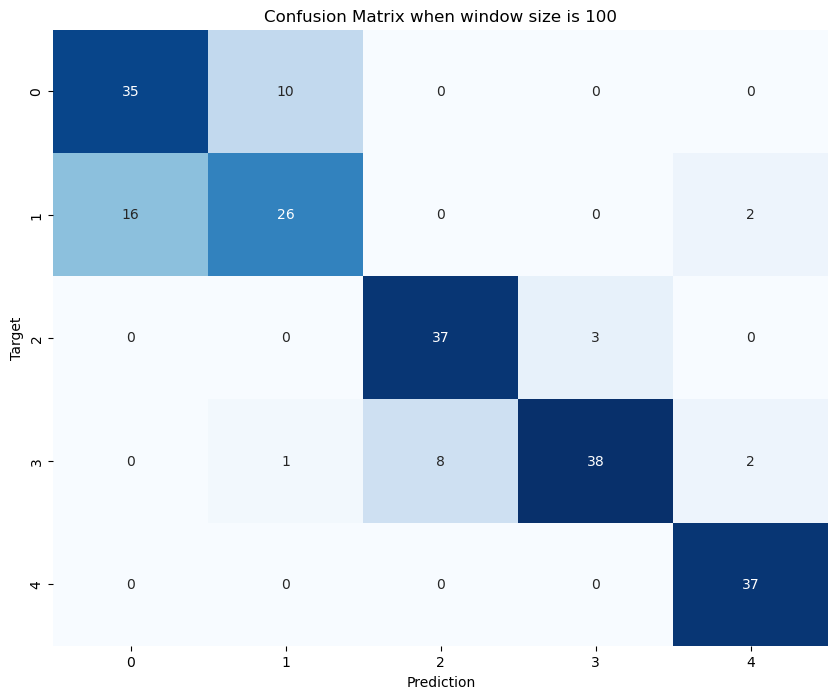

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 200
Accuracy : 0.822429906542056
Precision : 0.8356141982159467
recall : 0.822429906542056
f1-score : 0.8174809952339411



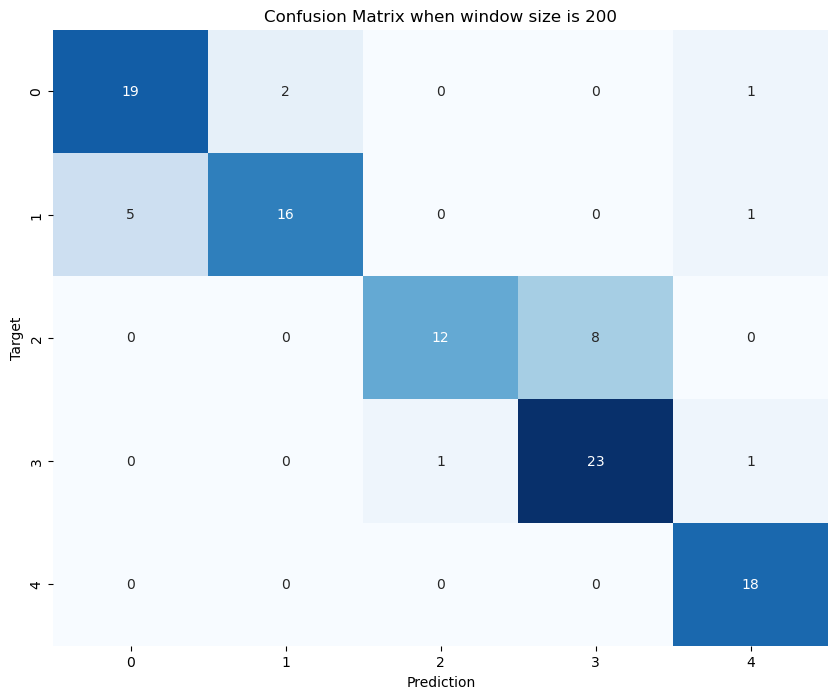

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 300
Accuracy : 0.7083333333333334
Precision : 0.7797301720912831
recall : 0.7083333333333334
f1-score : 0.6698231914510985



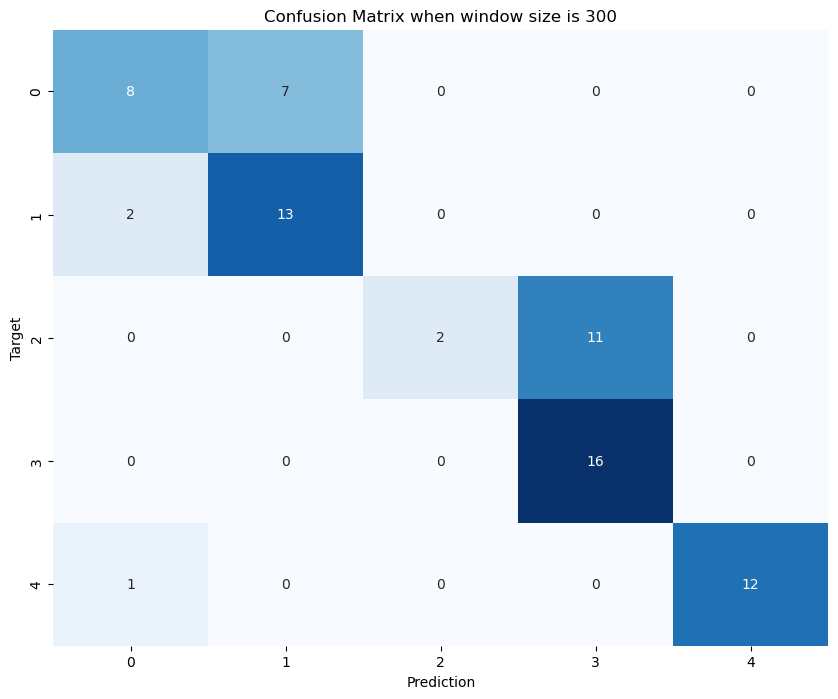

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 400
Accuracy : 0.8888888888888888
Precision : 0.8947655225433003
recall : 0.8888888888888888
f1-score : 0.8861505139867712



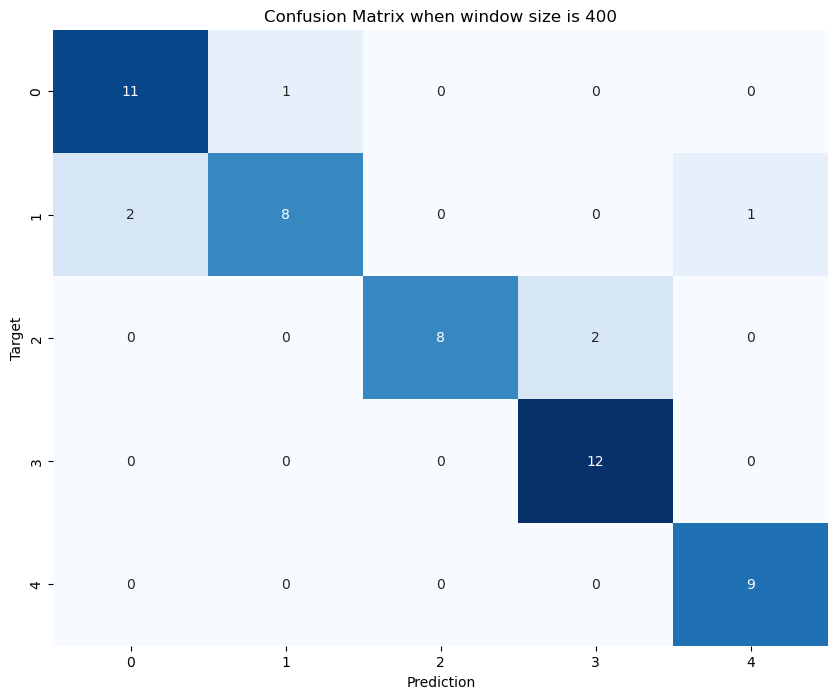

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 500
Accuracy : 0.8571428571428571
Precision : 0.8912087912087912
recall : 0.8571428571428571
f1-score : 0.8511072690639254



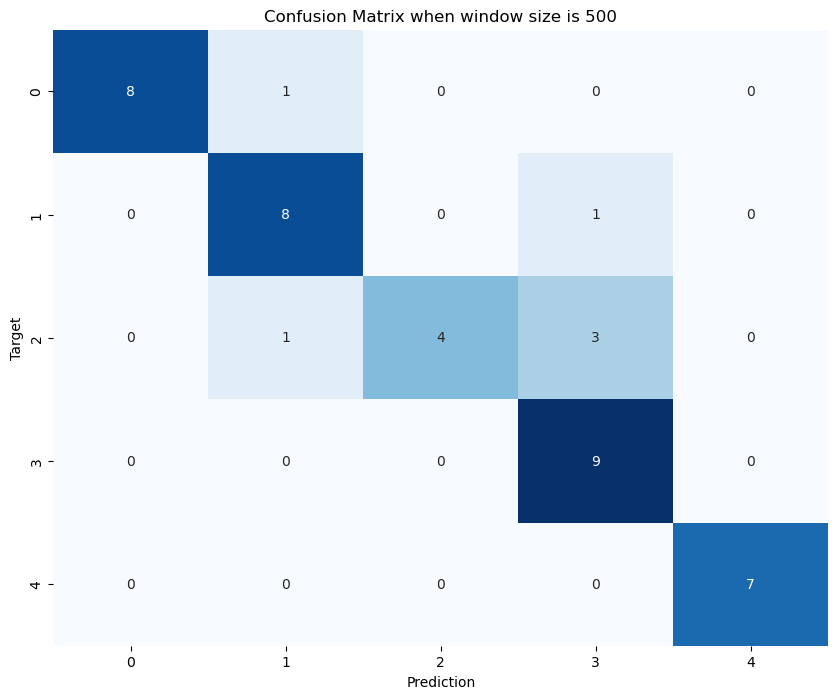

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 600
Accuracy : 0.8055555555555556
Precision : 0.847863247863248
recall : 0.8055555555555556
f1-score : 0.8014670514670514



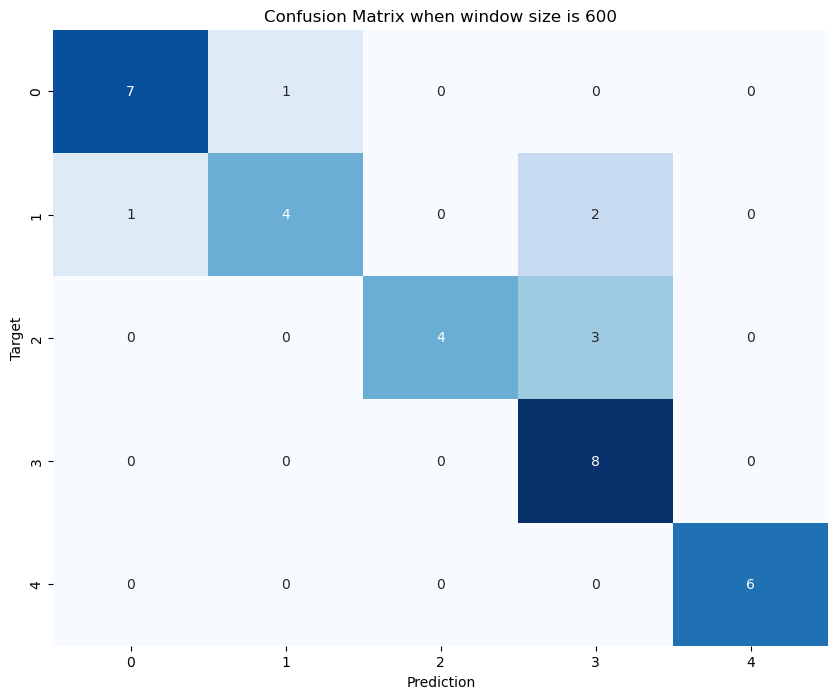

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 700
Accuracy : 0.8709677419354839
Precision : 0.9046082949308755
recall : 0.8709677419354839
f1-score : 0.8633776091081594



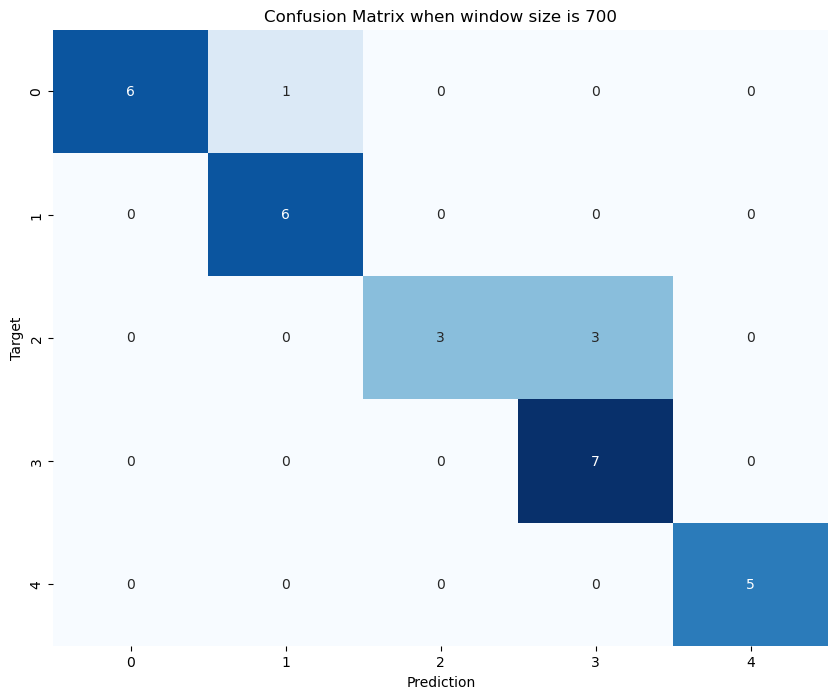

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 800
Accuracy : 0.9259259259259259
Precision : 0.937389770723104
recall : 0.9259259259259259
f1-score : 0.9252928141817031



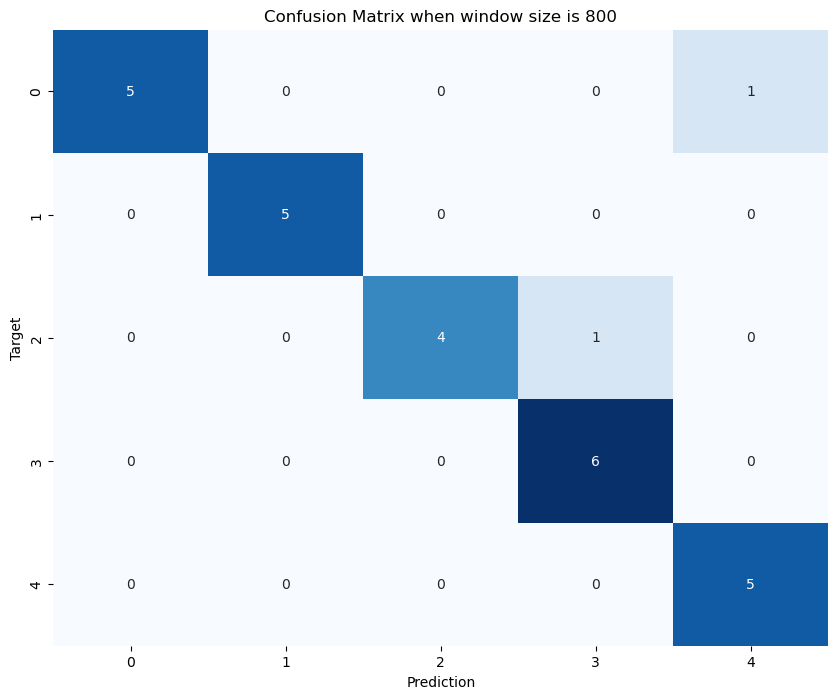

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 900
Accuracy : 0.625
Precision : 0.6041666666666666
recall : 0.625
f1-score : 0.5948773448773448



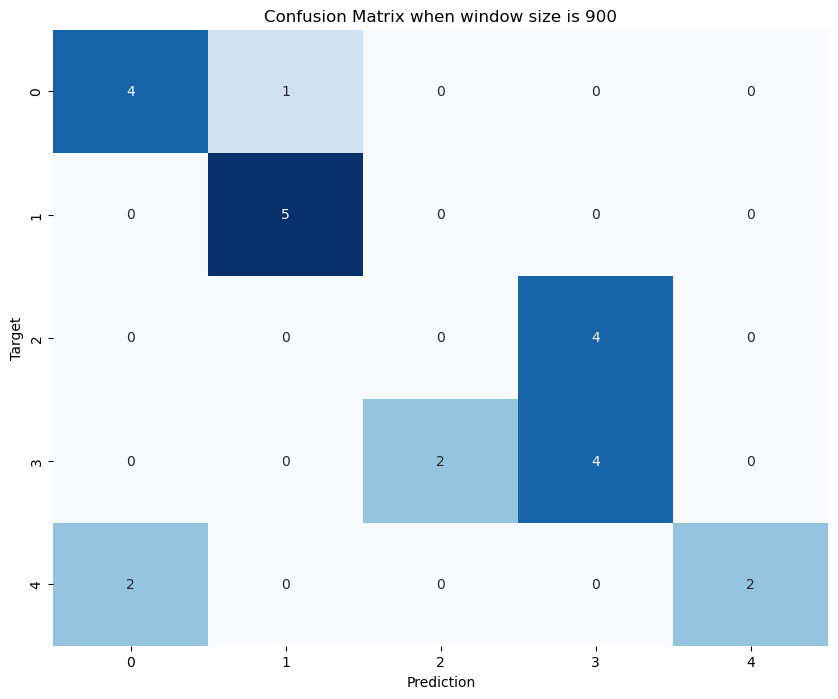

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1000
Accuracy : 0.9047619047619048
Precision : 0.9222222222222223
recall : 0.9047619047619048
f1-score : 0.9027691884834742



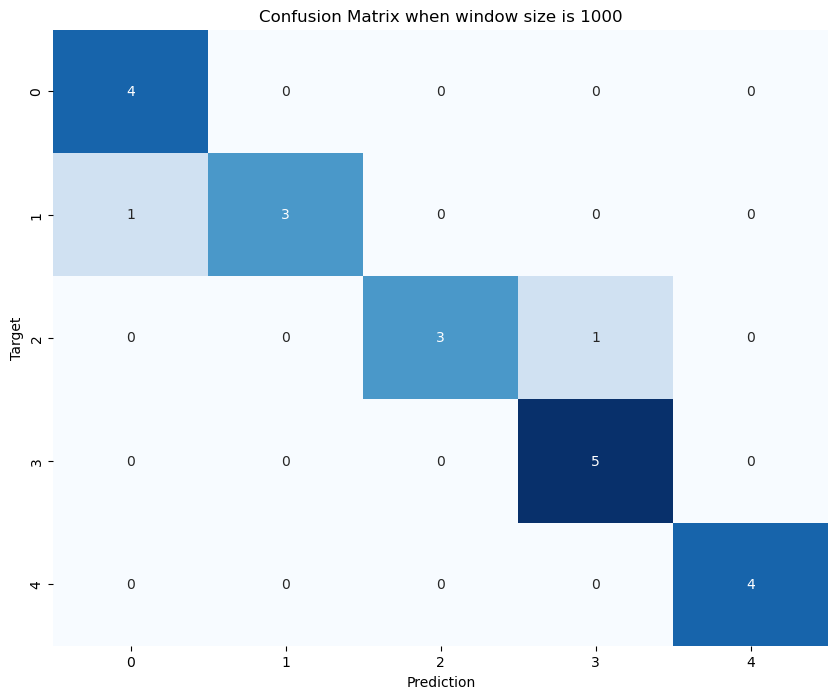

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1100
Accuracy : 0.7368421052631579
Precision : 0.7929824561403509
recall : 0.7368421052631579
f1-score : 0.7087719298245613



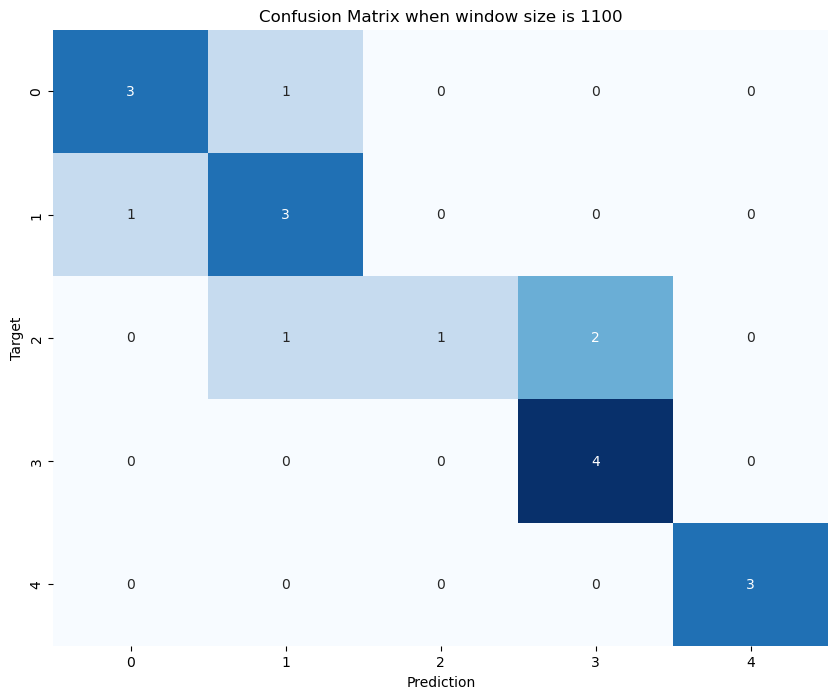

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1200
Accuracy : 0.7222222222222222
Precision : 0.6640211640211641
recall : 0.7222222222222222
f1-score : 0.6542087542087542



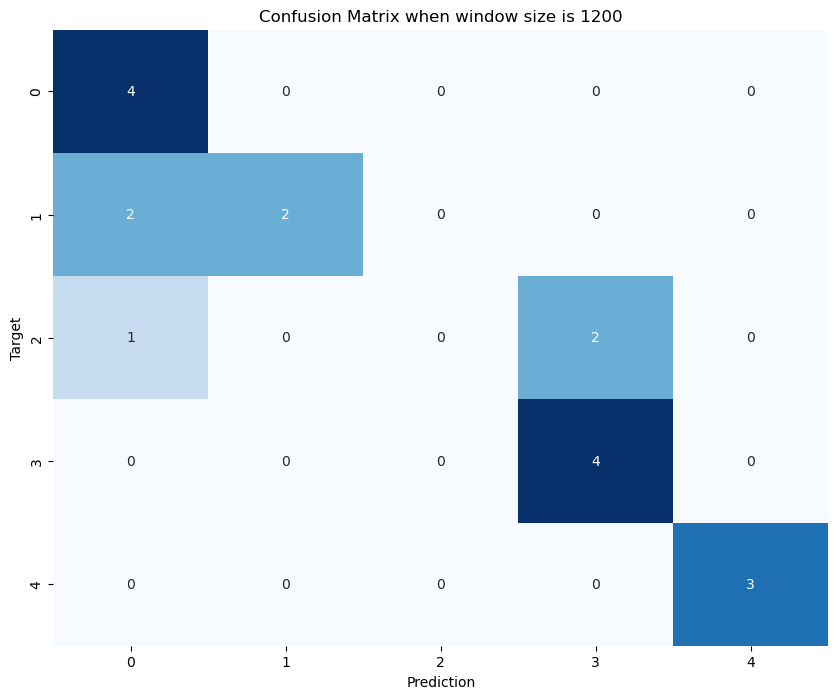

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1300
Accuracy : 0.9375
Precision : 0.95
recall : 0.9375
f1-score : 0.9347222222222222



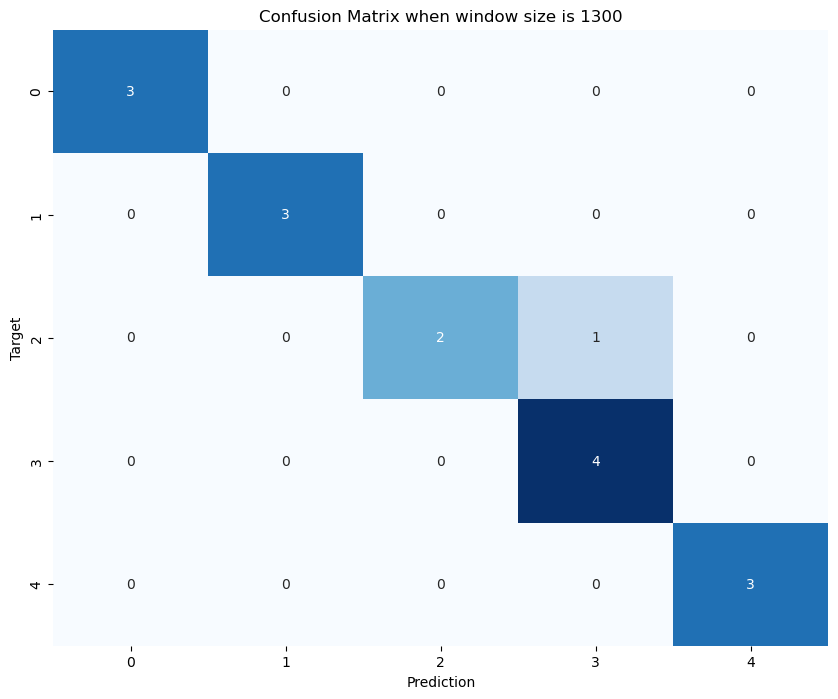

C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1400
Accuracy : 0.6666666666666666
Precision : 0.5666666666666667
recall : 0.6666666666666666
f1-score : 0.6



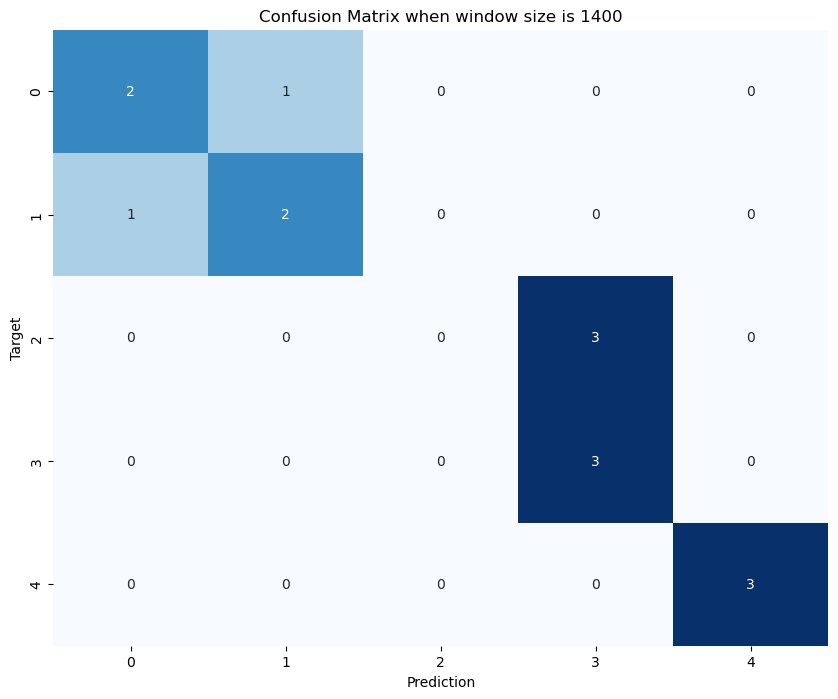

In [141]:
for key, df in feature_dataframes.items():
    X = df.drop('surface', axis = 1)
    y = df['surface']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = MLPClassifier(hidden_layer_sizes=(10, 10), activation='relu', random_state=42)

    model.fit(X_train_scaled, y_train) 

    y_pred = model.predict(X_test_scaled)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Scores when window size is {key}")
    print(f"Accuracy : {accuracy}")
    print(f"Precision : {precision}")
    print(f"recall : {recall}")
    print(f"f1-score : {f1}")
    print()

    # confusion matrix
    con_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(con_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix when window size is {key}")
    plt.xlabel("Prediction")
    plt.ylabel("Target")
    plt.show()

### One Hot Encoding

In [142]:
for key, df in feature_dataframes.items():
        df['asphalt'] = 0
        df['concrete'] = 0
        df['grass'] = 0
        df['stones'] = 0
        df['tiles'] = 0
        
        for index, row in df.iterrows():
            surface_value = row['surface']
            if surface_value == 0:
                df.at[index, 'asphalt'] = 1
            elif surface_value == 1:
                df.at[index, 'concrete'] = 1
            elif surface_value == 2:
                df.at[index, 'grass'] = 1
            elif surface_value == 3:
                df.at[index, 'stones'] = 1
            elif surface_value == 4:
                df.at[index, 'tiles'] = 1

In [143]:
for key, df in feature_dataframes.items():
    X = df.drop(['surface', 'asphalt', 'concrete', 'grass', 'stones', 'tiles'], axis = 1)
    y = df[['asphalt', 'concrete', 'grass', 'stones', 'tiles']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = MLPClassifier(hidden_layer_sizes=(10, 10), activation='relu', random_state=42)

    model.fit(X_train_scaled, y_train) 

    y_pred = model.predict(X_test_scaled)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Scores when window size is {key}")
    print(f"Accuracy : {accuracy}")
    print(f"Precision : {precision}")
    print(f"recall : {recall}")
    print(f"f1-score : {f1}")
    print()

    # confusion matrix
    # con_mat = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(con_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
    # plt.title(f"Confusion Matrix when window size is {key}")
    # plt.xlabel("Prediction")
    # plt.ylabel("Target")
    # plt.show()


C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 100
Accuracy : 0.7534883720930232
Precision : 0.8120901022643255
recall : 0.7674418604651163
f1-score : 0.7883113371764057



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 200
Accuracy : 0.8317757009345794
Precision : 0.8892968402314196
recall : 0.8317757009345794
f1-score : 0.8565643624383714



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 300
Accuracy : 0.5833333333333334
Precision : 0.6573660714285714
recall : 0.6111111111111112
f1-score : 0.5650510481155643



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 400
Accuracy : 0.7222222222222222
Precision : 0.9040404040404041
recall : 0.7222222222222222
f1-score : 0.7641908212560387



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 500
Accuracy : 0.6428571428571429
Precision : 0.8597789115646259
recall : 0.6428571428571429
f1-score : 0.6239586669792619



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 600
Accuracy : 0.5833333333333334
Precision : 0.6759259259259259
recall : 0.5833333333333334
f1-score : 0.5597222222222222



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 700
Accuracy : 0.5806451612903226
Precision : 0.6666666666666667
recall : 0.5806451612903226
f1-score : 0.6045266561395594



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 800
Accuracy : 0.7777777777777778
Precision : 0.7037037037037037
recall : 0.7777777777777778
f1-score : 0.7314814814814815



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 900
Accuracy : 0.625
Precision : 0.6480654761904762
recall : 0.625
f1-score : 0.5998168498168498



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1000
Accuracy : 0.7619047619047619
Precision : 0.6821428571428572
recall : 0.7619047619047619
f1-score : 0.706203849060992



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1100
Accuracy : 0.5789473684210527
Precision : 0.6798245614035088
recall : 0.5789473684210527
f1-score : 0.5844611528822055



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1200
Accuracy : 0.7777777777777778
Precision : 0.8194444444444444
recall : 0.7777777777777778
f1-score : 0.788888888888889



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores when window size is 1300
Accuracy : 0.75
Precision : 0.809375
recall : 0.8125
f1-score : 0.795436507936508

Scores when window size is 1400
Accuracy : 0.7333333333333333
Precision : 0.85
recall : 0.8666666666666667
f1-score : 0.8457142857142858



C:\Users\Praise\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
